# Test 4 - Comparison vs FM paper: CoinCollector, CookingGame, TreasureHunter

In [1]:
! tar czf Testing.tar *

In [ ]:
! nvidia-smi

In [1]:
import pickle
import random

In [3]:
import sys
sys.path.append("../Self-evaluation")

from self_evaluation import play, LLMAgentSelfEvaluate

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Game generation

Idea:
- two models used: no-think and 10-think
- different difficulty levels: 6 for coin collector, ~5 for common sense,~ 5 for cooking, 8 for treasure hunter
- 5 seeds per case (vs 40 in FM paper), 1 episode per seed
- total episodes: 240 (190 without commonsense)

In [2]:
levels = {"coin_collector": 6, "cooking": 5, "treasure_hunter": 8}
seeds = range(1,6)

In [ ]:
import subprocess

for game in levels.keys():
    if game == "cooking":
        continue
    for level in range(1, levels[game]+1):
        for seed in seeds:
            subprocess.run(["tw-make", f"tw-{game}", "--level", f"{level}", "--seed", f"{seed}", "--output", f"games/{game}/level{level}-seed{seed}.z8"]) 

In [ ]:
!tw-make tw-cooking --seed 1 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed1.z8
!tw-make tw-cooking --seed 2 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed2.z8
!tw-make tw-cooking --seed 3 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed3.z8
!tw-make tw-cooking --seed 4 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed4.z8
!tw-make tw-cooking --seed 5 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed5.z8

!tw-make tw-cooking --seed 1 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed1.z8
!tw-make tw-cooking --seed 2 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed2.z8
!tw-make tw-cooking --seed 3 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed3.z8
!tw-make tw-cooking --seed 4 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed4.z8
!tw-make tw-cooking --seed 5 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed5.z8

!tw-make tw-cooking --seed 1 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed1.z8
!tw-make tw-cooking --seed 2 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed2.z8
!tw-make tw-cooking --seed 3 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed3.z8
!tw-make tw-cooking --seed 4 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed4.z8
!tw-make tw-cooking --seed 5 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed5.z8

!tw-make tw-cooking --seed 1 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed1.z8
!tw-make tw-cooking --seed 2 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed2.z8
!tw-make tw-cooking --seed 3 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed3.z8
!tw-make tw-cooking --seed 4 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed4.z8
!tw-make tw-cooking --seed 5 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed5.z8

!tw-make tw-cooking --seed 1 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed1.z8
!tw-make tw-cooking --seed 2 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed2.z8
!tw-make tw-cooking --seed 3 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed3.z8
!tw-make tw-cooking --seed 4 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed4.z8
!tw-make tw-cooking --seed 5 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed5.z8

## Game running

In [3]:
n_think_indices = [0, 10]
n_episodes = 1
max_steps = 100

In [10]:
zipped_levels = list(zip(levels.keys(), levels.values()))
print(zipped_levels)

[('coin_collector', 6), ('cooking', 5), ('treasure_hunter', 8)]


In [ ]:
for n in n_think_indices:
    for game in levels.keys():
        for level in range(1, levels[game]+1):
            results_all_seeds = []
            for seed in seeds:
                results = play(LLMAgentSelfEvaluate(selfeval_turns=n, verbose=False),
                               f"games/{game}/level{level}-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
                results_all_seeds.append(results[0]) # only one episode
            with open(f"./Testing 4/{n}think_{game}_level{level}", "wb") as f:
                pickle.dump(results_all_seeds, f) # so we dump already with grouping by seed!!
                print("Data pickled.")
                f.close()

level1-seed1.z8.  	avg. steps:   1.0; avg. score:  1.0 / 1.
level1-seed2.z8.  	avg. steps:   1.0; avg. score:  1.0 / 1.
level1-seed3.z8.  	avg. steps:   1.0; avg. score:  1.0 / 1.
level1-seed4.z8.  	avg. steps:   1.0; avg. score:  1.0 / 1.
level1-seed5.z8.  	avg. steps:   1.0; avg. score:  1.0 / 1.
Data pickled.
level2-seed1.z8.  	avg. steps:   2.0; avg. score:  1.0 / 1.
level2-seed2.z8.  	avg. steps:   2.0; avg. score:  1.0 / 1.
level2-seed3.z8.  	avg. steps:   2.0; avg. score:  1.0 / 1.
level2-seed4.z8.  	avg. steps:   2.0; avg. score:  1.0 / 1.
level2-seed5.z8.  	avg. steps:   2.0; avg. score:  1.0 / 1.
Data pickled.
level3-seed1.z8.  	avg. steps:  88.0; avg. score:  1.0 / 1.
level3-seed2.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level3-seed3.z8.  	avg. steps:   3.0; avg. score:  1.0 / 1.
level3-seed4.z8.  	avg. steps:   3.0; avg. score:  1.0 / 1.
level3-seed5.z8.  	avg. steps:   3.0; avg. score:  1.0 / 1.
Data pickled.
level4-seed1.z8.  	avg. steps:  97.0; avg. score:  1.0 / 1

# Data aggregation for visualization

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [5]:
max_scores_cooking = [5, 8, 11, 5, 8]

In [7]:
coin_nothink = []
coin_nothink_ci = []
coin_10think = []
coin_10think_ci = []
treasure_nothink = []
treasure_nothink_ci = []
treasure_10think = []
treasure_10think_ci = []
cooking_nothink = []
cooking_nothink_ci = []
cooking_10think = []
cooking_10think_ci = []

final_arrays = {"coin_collector": {0: (coin_nothink, coin_nothink_ci), 10: (coin_10think, coin_10think_ci)},
                "treasure_hunter": {0: (treasure_nothink, treasure_nothink_ci), 10: (treasure_10think, treasure_10think_ci)},
                "cooking": {0: (cooking_nothink, cooking_nothink_ci), 10: (cooking_10think, cooking_10think_ci)}}

for n in n_think_indices:
    for game in levels.keys():
        for level in range(1, levels[game]+1):
            results_all_seeds = []
            with open(f"./Testing 4/{n}think_{game}_level{level}", "rb") as f:
                results_all_seeds = pickle.load(f)
                f.close()
            final_scores = [run[-1][1] for run in results_all_seeds] # last step, score
            if game == "cooking":
                final_scores = np.array(final_scores) / max_scores_cooking[level - 1] # we need to normalize the results of cooking
            avg_final_score = np.mean(final_scores) # i think they're already normalized to 1
            bootstrap_results = bootstrap(data=(final_scores,), 
                                statistic=np.mean,
                                method="basic",
                                n_resamples=1000,
                                confidence_level=0.9)
            final_arrays[game][n][0].append(avg_final_score)
            final_arrays[game][n][1].append((bootstrap_results.confidence_interval.high, bootstrap_results.confidence_interval.low))

# Visualization

In [31]:
figsize=(11,20)

In [28]:
ylims = {"coin_collector": (0,1),
         "cooking": (0, 0.5),
         "treasure_hunter": (0.1, 1)}

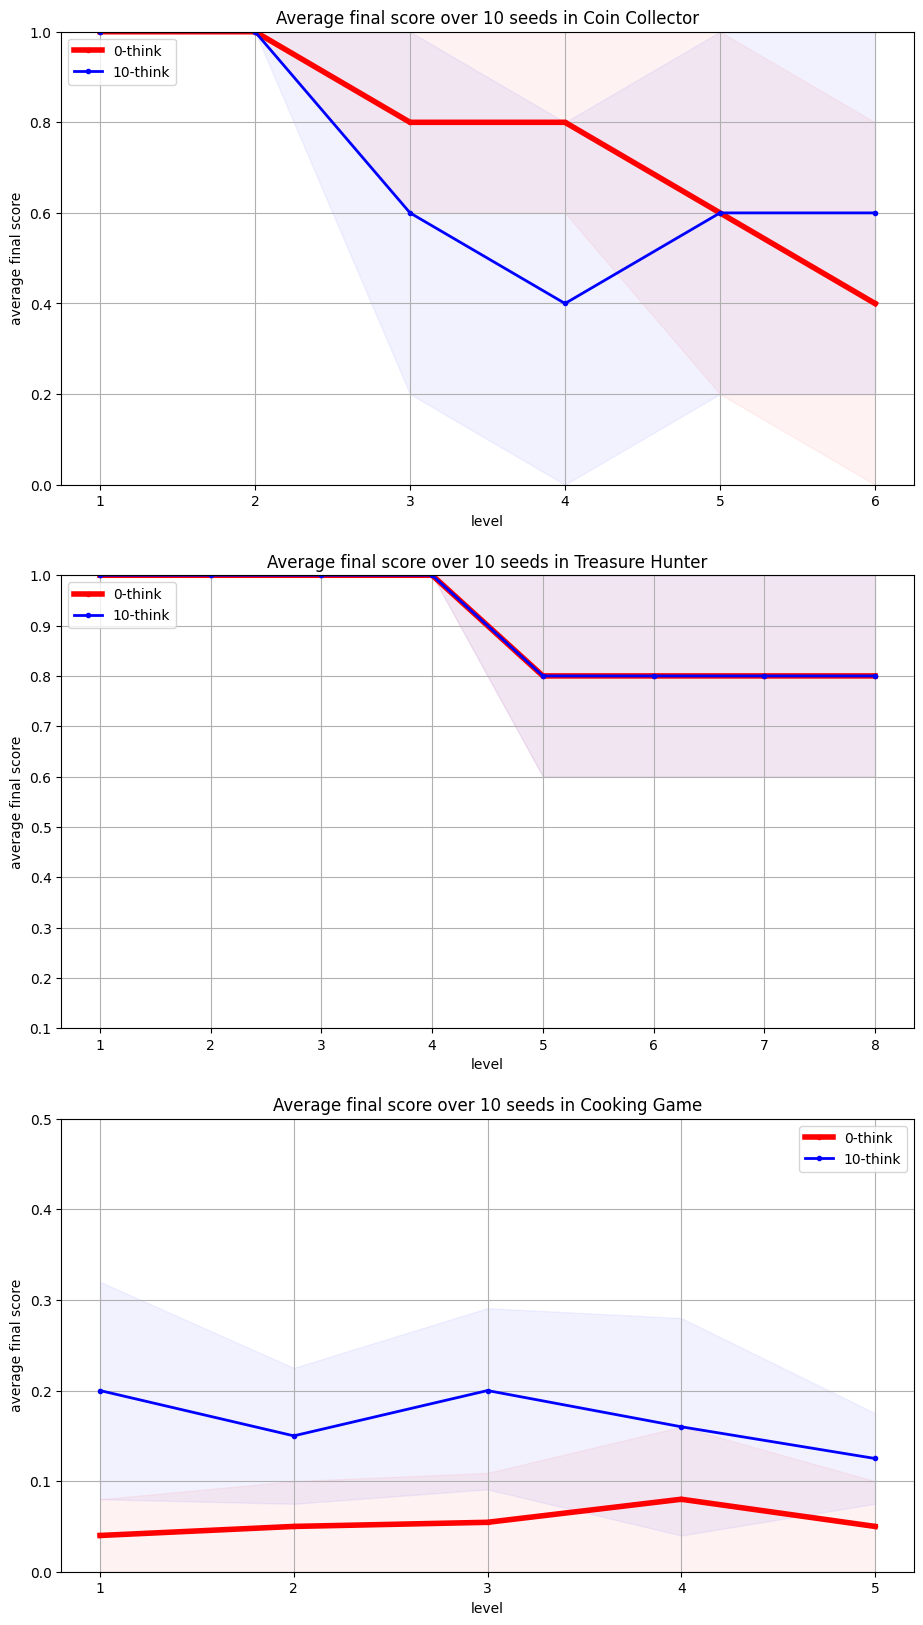

In [32]:
fig, axes = plt.subplots(3,1, figsize=figsize)
prettified_names = {"coin_collector": "Coin Collector", "treasure_hunter": "Treasure Hunter", "cooking": "Cooking Game"}

for i, game in enumerate(final_arrays.keys()):
    ax = axes[i]
    x = list(range(1, levels[game]+1))
    y_0, y_0_ci = final_arrays[game][0]
    y_10, y_10_ci = final_arrays[game][10]

    ax.plot(x, y_0, label="0-think", marker=".", linestyle="-", color="red", linewidth=4)
    ax.plot(x, y_10, label="10-think", marker=".", linestyle="-", color="blue", linewidth=2)

    ax.fill_between(x,
                    np.clip([i[0] for i in y_0_ci], 0, 1),
                    np.clip([i[1] for i in y_0_ci], 0, 1),
                    alpha=0.05, color="red")
    ax.fill_between(x,
                    np.clip([i[0] for i in y_10_ci], 0, 1),
                    np.clip([i[1] for i in y_10_ci], 0, 1),
                    alpha=0.05, color="blue")


    ax.set_title(f"Average final score over 10 seeds in {prettified_names[game]}")
    ax.set_xlabel('level')
    ax.set_ylabel('average final score')
    ax.legend()

    ax.set_xticks(x)
    ax.set_ylim(ylims[game][0], ylims[game][1])
    ax.grid()

plt.show()